# Single asperity simulations

In this tutorial, we simulate slip on a fault with a single velocity-weakening asperity, embedded in a velocity-strengthening (creeping) matrix. We begin by importing some modules.

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.join("/", "home")
qdyn_dir = os.path.join(base_dir, "qdyn", "src")
plot_dir = os.path.join(base_dir, "qdyn", "utils", "post_processing")

for path in (qdyn_dir, plot_dir):
    if path not in sys.path:
        sys.path.append(path)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

To preprare a simulation, the global simulation and mesh parameters will have to be specified. This is done in three steps: 

1. Specify global parameters, like simulation duration, output resolution, mesh size, and default mesh values
2. Render the mesh (assigning default values to every element)
3. Override the default mesh parameter values to create heterogeneity in the simulation

In this simulation, the only heterogeneity stems from a lateral variation in the direct effect parameter $a$, which is chosen such that the asperity has $(a-b) < 0$, and such that the matrix has $(a - b) > 0$.

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
Lasp = 7                    # Length of asperity / nucleation length
L = 5                       # Length of fault / nucleation length
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 0         # Periodic fault
set_dict["TMAX"] = 15*t_yr     # Maximum simulation time [s]
set_dict["NTOUT"] = 100        # Save output every N steps
set_dict["NXOUT"] = 2          # Snapshot resolution (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity [m/s]
set_dict["MU"] = 3e10          # Shear modulus [Pa]
set_dict["W"] = 50e3           # Loading distance [m]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.9e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = Lb / cab_ratio
# Length of asperity [m]
Lasp *= Lc
# Fault length [m]
L *= Lasp

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Location on the fault (middle) for time series output
set_dict["IC"] = N // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"] = set_dict["SET_DICT_RSF"]["B"] * (1 + cab_ratio*(1 - 2*np.exp(-(2*x/Lasp)**6)))

# Write input to qdyn.in
p.write_input()

True

To see the effect of setting a heterogeneous value of a over the mesh, we can plot $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


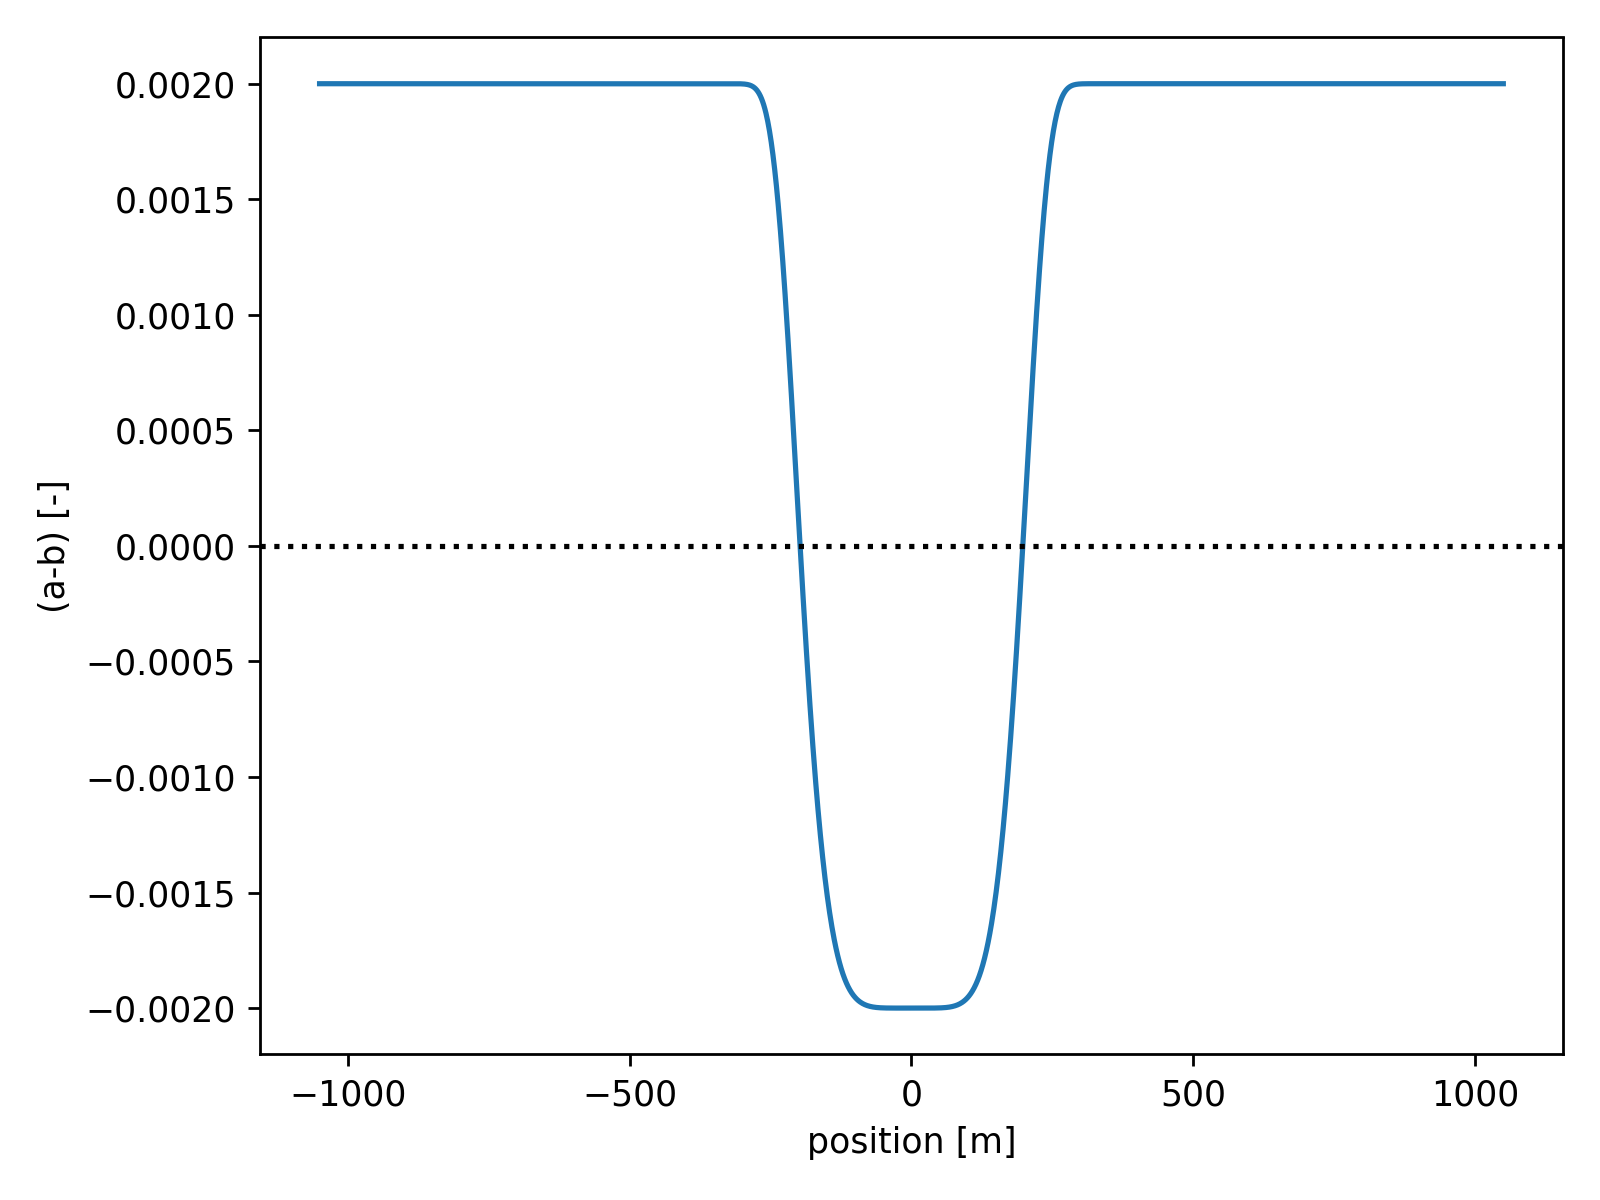

In [3]:
plt.clf()
plt.plot(x, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [m]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
plt.show()

As desired, the asperity is defined by $(a-b) < 0$, embedded in a stable matrix with $(a-b) > 0$.

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that in this notebook, the screen output (`stdout`) is captured by the console, so you won't see any output here.

In [4]:
p.run()

 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    5000000.0000000000     
 Intializing kernel: ...
 FFT applied
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =    3.7699111843077513E-003
 K/Kb =    7.5398223686155028E-004

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.101E-04   0.100E+03
    100   0.596E-03   0.102E-05   0.851E-01   0.100E+03
    200   0.405E-04   0.102E-05   0.148E+01   0.100E+03
    300   0.316E-04   0.102E-05   0.182E+01   0.100E+03
    400   0.278E-04   0.102E-05   0.203E+01   0.100E+03
    500   0.257E-04   0.102E-05   0.219E+01   0.100E+03
    600   0.245E-04   0.102E-05   0.229E+01   0.100E+03
    700   0.235E-04   0.102E-05   0.238E+01   0.100E+03
    800   0.226E-04   

  13800   0.175E-04   0.102E-05   0.319E+01   0.100E+03
  13900   0.175E-04   0.102E-05   0.320E+01   0.100E+03
  14000   0.174E-04   0.102E-05   0.322E+01   0.100E+03
  14100   0.173E-04   0.102E-05   0.324E+01   0.100E+03
  14200   0.174E-04   0.102E-05   0.325E+01   0.100E+03
  14300   0.172E-04   0.102E-05   0.328E+01   0.100E+03
  14400   0.171E-04   0.102E-05   0.330E+01   0.100E+03
  14500   0.170E-04   0.102E-05   0.333E+01   0.100E+03
  14600   0.168E-04   0.102E-05   0.337E+01   0.100E+03
  14700   0.166E-04   0.102E-05   0.341E+01   0.100E+03
  14800   0.164E-04   0.102E-05   0.349E+01   0.100E+03
  14900   0.160E-04   0.102E-05   0.361E+01   0.100E+03
  15000   0.151E-04   0.102E-05   0.384E+01   0.100E+03
  15100   0.133E-03   0.102E-05   0.365E+01   0.100E+03
  15200   0.209E-03   0.103E-05   0.280E+01   0.100E+03
  15300   0.299E-03   0.103E-05   0.228E+01   0.100E+03
  15400   0.404E-03   0.103E-05   0.194E+01   0.100E+03
  15500   0.529E-03   0.103E-05   0.170E+01   0.

  28500   0.149E-02   0.132E-05   0.659E-01   0.100E+03
  28600   0.154E-02   0.132E-05   0.633E-01   0.100E+03
  28700   0.159E-02   0.133E-05   0.607E-01   0.100E+03
  28800   0.164E-02   0.133E-05   0.582E-01   0.100E+03
  28900   0.169E-02   0.134E-05   0.558E-01   0.100E+03
  29000   0.175E-02   0.134E-05   0.534E-01   0.100E+03
  29100   0.181E-02   0.135E-05   0.510E-01   0.100E+03
  29200   0.188E-02   0.136E-05   0.488E-01   0.100E+03
  29300   0.195E-02   0.136E-05   0.465E-01   0.100E+03
  29400   0.202E-02   0.137E-05   0.444E-01   0.100E+03
  29500   0.211E-02   0.137E-05   0.423E-01   0.100E+03
  29600   0.219E-02   0.138E-05   0.402E-01   0.100E+03
  29700   0.229E-02   0.139E-05   0.382E-01   0.100E+03
  29800   0.239E-02   0.140E-05   0.363E-01   0.100E+03
  29900   0.250E-02   0.140E-05   0.344E-01   0.100E+03
  30000   0.262E-02   0.141E-05   0.326E-01   0.100E+03
  30100   0.275E-02   0.142E-05   0.308E-01   0.100E+03
  30200   0.289E-02   0.143E-05   0.291E-01   0.

  43500   0.516E-03   0.293E-04   0.810E-01   0.100E+03
  43600   0.771E-03   0.293E-04   0.544E-01   0.100E+03
  43700   0.126E-02   0.293E-04   0.325E-01   0.100E+03
  43800   0.229E-02   0.293E-04   0.176E-01   0.100E+03
  43900   0.468E-02   0.293E-04   0.893E-02   0.100E+03
  44000   0.996E-02   0.294E-04   0.449E-02   0.100E+03
  44100   0.216E-01   0.294E-04   0.232E-02   0.100E+03
  44200   0.528E-01   0.295E-04   0.117E-02   0.100E+03
  44300   0.242E+00   0.299E-04   0.408E-03   0.100E+03
  44400   0.839E+00   0.317E-04   0.125E-03   0.100E+03
  44500   0.140E+01   0.350E-04   0.731E-04   0.100E+03
  44600   0.141E+01   0.405E-04   0.440E-04   0.100E+03
  44700   0.633E+00   0.435E-04   0.706E-04   0.100E+03
  44800   0.206E+00   0.448E-04   0.213E-03   0.100E+03
  44900   0.248E-02   0.450E-04   0.217E-01   0.100E+03
  45000   0.494E-03   0.450E-04   0.878E-01   0.100E+03
  45100   0.606E-03   0.450E-04   0.704E-01   0.100E+03
  45200   0.588E-03   0.450E-04   0.730E-01   0.

  58400   0.972E+01   0.228E-03   0.105E-04   0.100E+03
  58500   0.104E+02   0.264E-03   0.653E-05   0.100E+03
  58600   0.714E+01   0.292E-03   0.618E-05   0.100E+03
  58700   0.261E+01   0.307E-03   0.170E-04   0.100E+03
  58800   0.309E-01   0.310E-03   0.169E-02   0.100E+03
  58900   0.155E-02   0.310E-03   0.233E-01   0.100E+03
  59000   0.203E-02   0.311E-03   0.176E-01   0.100E+03
  59100   0.221E-02   0.311E-03   0.170E-01   0.100E+03
  59200   0.177E-02   0.311E-03   0.199E-01   0.100E+03
  59300   0.137E-02   0.311E-03   0.263E-01   0.100E+03
  59400   0.975E-03   0.311E-03   0.374E-01   0.100E+03
  59500   0.684E-03   0.311E-03   0.549E-01   0.100E+03
  59600   0.489E-03   0.311E-03   0.786E-01   0.100E+03
  59700   0.393E-03   0.311E-03   0.105E+00   0.100E+03
  59800   0.342E-03   0.311E-03   0.131E+00   0.100E+03
  59900   0.283E-03   0.311E-03   0.153E+00   0.100E+03
  60000   0.255E-03   0.311E-03   0.170E+00   0.100E+03
  60100   0.247E-03   0.311E-03   0.183E+00   0.

  73200   0.254E-03   0.167E-02   0.165E+00   0.100E+03
  73300   0.250E-03   0.167E-02   0.183E+00   0.100E+03
  73400   0.223E-03   0.167E-02   0.196E+00   0.100E+03
  73500   0.229E-03   0.167E-02   0.209E+00   0.100E+03
  73600   0.206E-03   0.167E-02   0.216E+00   0.100E+03
  73700   0.223E-03   0.167E-02   0.221E+00   0.100E+03
  73800   0.204E-03   0.167E-02   0.219E+00   0.100E+03
  73900   0.214E-03   0.167E-02   0.213E+00   0.100E+03
  74000   0.247E-03   0.167E-02   0.201E+00   0.100E+03
  74100   0.243E-03   0.167E-02   0.183E+00   0.100E+03
  74200   0.266E-03   0.167E-02   0.161E+00   0.100E+03
  74300   0.322E-03   0.167E-02   0.136E+00   0.100E+03
  74400   0.370E-03   0.167E-02   0.110E+00   0.100E+03
  74500   0.441E-03   0.167E-02   0.834E-01   0.100E+03
  74600   0.675E-03   0.167E-02   0.600E-01   0.100E+03
  74700   0.869E-03   0.167E-02   0.395E-01   0.100E+03
  74800   0.156E-02   0.167E-02   0.242E-01   0.100E+03
  74900   0.268E-02   0.167E-02   0.136E-01   0.

  88200   0.234E-02   0.111E-01   0.145E-01   0.100E+03
  88300   0.843E-03   0.111E-01   0.407E-01   0.100E+03
  88400   0.440E-03   0.111E-01   0.825E-01   0.100E+03
  88500   0.334E-03   0.111E-01   0.118E+00   0.100E+03
  88600   0.310E-03   0.111E-01   0.143E+00   0.100E+03
  88700   0.251E-03   0.111E-01   0.163E+00   0.100E+03
  88800   0.239E-03   0.111E-01   0.181E+00   0.100E+03
  88900   0.228E-03   0.111E-01   0.196E+00   0.100E+03
  89000   0.208E-03   0.111E-01   0.211E+00   0.100E+03
  89100   0.209E-03   0.111E-01   0.224E+00   0.100E+03
  89200   0.193E-03   0.111E-01   0.236E+00   0.100E+03
  89300   0.192E-03   0.111E-01   0.242E+00   0.100E+03
  89400   0.193E-03   0.111E-01   0.246E+00   0.100E+03
  89500   0.187E-03   0.111E-01   0.242E+00   0.100E+03
  89600   0.203E-03   0.111E-01   0.235E+00   0.100E+03
  89700   0.204E-03   0.111E-01   0.220E+00   0.100E+03
  89800   0.211E-03   0.111E-01   0.203E+00   0.100E+03
  89900   0.239E-03   0.111E-01   0.182E+00   0.

 103200   0.254E+00   0.443E-01   0.150E-03   0.100E+03
 103300   0.464E+00   0.443E-01   0.772E-04   0.100E+03
 103400   0.953E+00   0.443E-01   0.421E-04   0.100E+03
 103500   0.160E+01   0.443E-01   0.240E-04   0.100E+03
 103600   0.275E+01   0.443E-01   0.144E-04   0.100E+03
 103700   0.473E+01   0.443E-01   0.909E-05   0.100E+03
 103800   0.712E+01   0.444E-01   0.598E-05   0.100E+03
 103900   0.110E+02   0.444E-01   0.403E-05   0.100E+03
 104000   0.172E+02   0.444E-01   0.275E-05   0.100E+03
 104100   0.263E+02   0.445E-01   0.189E-05   0.100E+03
 104200   0.438E+02   0.446E-01   0.126E-05   0.100E+03
 104300   0.879E+02   0.448E-01   0.767E-06   0.100E+03
 104400   0.295E+03   0.453E-01   0.344E-06   0.100E+03
 104500   0.729E+03   0.471E-01   0.145E-06   0.100E+03
 104600   0.129E+04   0.500E-01   0.791E-07   0.100E+03
 104700   0.226E+04   0.555E-01   0.450E-07   0.100E+03
 104800   0.376E+04   0.649E-01   0.271E-07   0.100E+03
 104900   0.420E+04   0.790E-01   0.175E-07   0.

 118200   0.198E+05   0.307E+00   0.516E-08   0.100E+03
 118300   0.141E+05   0.365E+00   0.369E-08   0.100E+03
 118400   0.498E+04   0.395E+00   0.851E-08   0.100E+03
 118500   0.499E+02   0.400E+00   0.106E-05   0.100E+03
 118600   0.271E+01   0.400E+00   0.121E-04   0.100E+03
 118700   0.349E+01   0.400E+00   0.978E-05   0.100E+03
 118800   0.342E+01   0.400E+00   0.976E-05   0.100E+03
 118900   0.288E+01   0.400E+00   0.120E-04   0.100E+03
 119000   0.195E+01   0.400E+00   0.170E-04   0.100E+03
 119100   0.120E+01   0.400E+00   0.278E-04   0.100E+03
 119200   0.606E+00   0.400E+00   0.529E-04   0.100E+03
 119300   0.253E+00   0.400E+00   0.125E-03   0.100E+03
 119400   0.720E-01   0.400E+00   0.436E-03   0.100E+03
 119500   0.946E-02   0.400E+00   0.444E-02   0.100E+03
 119600   0.740E-03   0.400E+00   0.448E-01   0.100E+03
 119700   0.384E-03   0.400E+00   0.998E-01   0.100E+03
 119800   0.297E-03   0.400E+00   0.131E+00   0.100E+03
 119900   0.254E-03   0.400E+00   0.151E+00   0.

 133200   0.592E+02   0.156E+01   0.921E-06   0.100E+03
 133300   0.624E+01   0.156E+01   0.527E-05   0.100E+03
 133400   0.806E+01   0.156E+01   0.420E-05   0.100E+03
 133500   0.807E+01   0.156E+01   0.425E-05   0.100E+03
 133600   0.641E+01   0.156E+01   0.523E-05   0.100E+03
 133700   0.474E+01   0.156E+01   0.750E-05   0.100E+03
 133800   0.275E+01   0.156E+01   0.123E-04   0.100E+03
 133900   0.136E+01   0.156E+01   0.234E-04   0.100E+03
 134000   0.588E+00   0.156E+01   0.547E-04   0.100E+03
 134100   0.190E+00   0.156E+01   0.179E-03   0.100E+03
 134200   0.310E-01   0.156E+01   0.126E-02   0.100E+03
 134300   0.183E-02   0.156E+01   0.195E-01   0.100E+03
 134400   0.456E-03   0.156E+01   0.773E-01   0.100E+03
 134500   0.289E-03   0.156E+01   0.116E+00   0.100E+03
 134600   0.303E-03   0.156E+01   0.139E+00   0.100E+03
 134700   0.211E-03   0.156E+01   0.157E+00   0.100E+03
 134800   0.246E-03   0.156E+01   0.172E+00   0.100E+03
 134900   0.180E-03   0.156E+01   0.187E+00   0.

 148200   0.637E+04   0.271E+01   0.142E-07   0.100E+03
 148300   0.165E+05   0.275E+01   0.632E-08   0.100E+03
 148400   0.270E+05   0.281E+01   0.380E-08   0.100E+03
 148500   0.486E+05   0.293E+01   0.210E-08   0.100E+03
 148600   0.779E+05   0.313E+01   0.131E-08   0.100E+03
 148700   0.119E+06   0.344E+01   0.861E-09   0.100E+03
 148800   0.910E+05   0.380E+01   0.649E-09   0.100E+03
 148900   0.498E+05   0.402E+01   0.815E-09   0.100E+03
 149000   0.130E+05   0.411E+01   0.321E-08   0.100E+03
 149100   0.534E+02   0.413E+01   0.102E-05   0.100E+03
 149200   0.540E+01   0.413E+01   0.579E-05   0.100E+03
 149300   0.718E+01   0.413E+01   0.446E-05   0.100E+03
 149400   0.763E+01   0.413E+01   0.434E-05   0.100E+03
 149500   0.626E+01   0.413E+01   0.518E-05   0.100E+03
 149600   0.474E+01   0.413E+01   0.723E-05   0.100E+03
 149700   0.280E+01   0.413E+01   0.115E-04   0.100E+03
 149800   0.155E+01   0.413E+01   0.211E-04   0.100E+03
 149900   0.687E+00   0.413E+01   0.457E-04   0.

 163100   0.446E+01   0.578E+01   0.857E-05   0.100E+03
 163200   0.751E+01   0.578E+01   0.466E-05   0.100E+03
 163300   0.135E+02   0.578E+01   0.266E-05   0.100E+03
 163400   0.241E+02   0.578E+01   0.159E-05   0.100E+03
 163500   0.384E+02   0.578E+01   0.980E-06   0.100E+03
 163600   0.651E+02   0.578E+01   0.633E-06   0.100E+03
 163700   0.953E+02   0.578E+01   0.421E-06   0.100E+03
 163800   0.140E+03   0.578E+01   0.287E-06   0.100E+03
 163900   0.207E+03   0.578E+01   0.202E-06   0.100E+03
 164000   0.294E+03   0.578E+01   0.145E-06   0.100E+03
 164100   0.416E+03   0.578E+01   0.105E-06   0.100E+03
 164200   0.583E+03   0.578E+01   0.775E-07   0.100E+03
 164300   0.834E+03   0.578E+01   0.574E-07   0.100E+03
 164400   0.117E+04   0.579E+01   0.423E-07   0.100E+03
 164500   0.175E+04   0.579E+01   0.308E-07   0.100E+03
 164600   0.287E+04   0.580E+01   0.213E-07   0.100E+03
 164700   0.641E+04   0.581E+01   0.130E-07   0.100E+03
 164800   0.217E+05   0.585E+01   0.593E-08   0.

 178100   0.274E-03   0.933E+01   0.142E+00   0.100E+03
 178200   0.320E-03   0.933E+01   0.116E+00   0.100E+03
 178300   0.420E-03   0.933E+01   0.899E-01   0.100E+03
 178400   0.639E-03   0.933E+01   0.658E-01   0.100E+03
 178500   0.799E-03   0.933E+01   0.450E-01   0.100E+03
 178600   0.113E-02   0.933E+01   0.288E-01   0.100E+03
 178700   0.181E-02   0.933E+01   0.172E-01   0.100E+03
 178800   0.323E-02   0.933E+01   0.963E-02   0.100E+03
 178900   0.717E-02   0.933E+01   0.505E-02   0.100E+03
 179000   0.123E-01   0.933E+01   0.251E-02   0.100E+03
 179100   0.303E-01   0.933E+01   0.123E-02   0.100E+03
 179200   0.550E-01   0.933E+01   0.593E-03   0.100E+03
 179300   0.118E+00   0.933E+01   0.283E-03   0.100E+03
 179400   0.272E+00   0.933E+01   0.135E-03   0.100E+03
 179500   0.504E+00   0.933E+01   0.655E-04   0.100E+03
 179600   0.103E+01   0.933E+01   0.324E-04   0.100E+03
 179700   0.235E+01   0.933E+01   0.165E-04   0.100E+03
 179800   0.413E+01   0.933E+01   0.866E-05   0.

 193100   0.166E-03   0.130E+02   0.290E+00   0.100E+03
 193200   0.118E-03   0.130E+02   0.303E+00   0.100E+03
 193300   0.144E-03   0.130E+02   0.316E+00   0.100E+03
 193400   0.118E-03   0.130E+02   0.323E+00   0.100E+03
 193500   0.125E-03   0.130E+02   0.330E+00   0.100E+03
 193600   0.119E-03   0.130E+02   0.332E+00   0.100E+03
 193700   0.120E-03   0.130E+02   0.334E+00   0.100E+03
 193800   0.124E-03   0.130E+02   0.330E+00   0.100E+03
 193900   0.120E-03   0.130E+02   0.326E+00   0.100E+03
 194000   0.135E-03   0.130E+02   0.316E+00   0.100E+03
 194100   0.124E-03   0.130E+02   0.307E+00   0.100E+03
 194200   0.158E-03   0.130E+02   0.291E+00   0.100E+03
 194300   0.134E-03   0.130E+02   0.276E+00   0.100E+03
 194400   0.186E-03   0.130E+02   0.254E+00   0.100E+03
 194500   0.167E-03   0.130E+02   0.233E+00   0.100E+03
 194600   0.181E-03   0.130E+02   0.209E+00   0.100E+03
 194700   0.226E-03   0.130E+02   0.183E+00   0.100E+03
 194800   0.252E-03   0.130E+02   0.157E+00   0.

0

During the simulation, output is flushed to disk every `NTOUT` time steps. This output can be reloaded without re-running the simulation, so you only have to call `p.run()` again if you made any changes to the input parameters. To read/process the output, call:

In [5]:
p.read_output()

True

For this tutorial, we use a library (`plot_functions.py`) that handles the plotting logistics. This library can be found in the `utils/post_processing` folder in the QDYN directory. To get a general impression of how our fault behaved, we plot the time series of the shear stress $\tau$ and state $\theta$ recorded at the centre of the fault, and the maximum slip rate $v_{max}$ recorded over the entire fault.

<IPython.core.display.Javascript object>


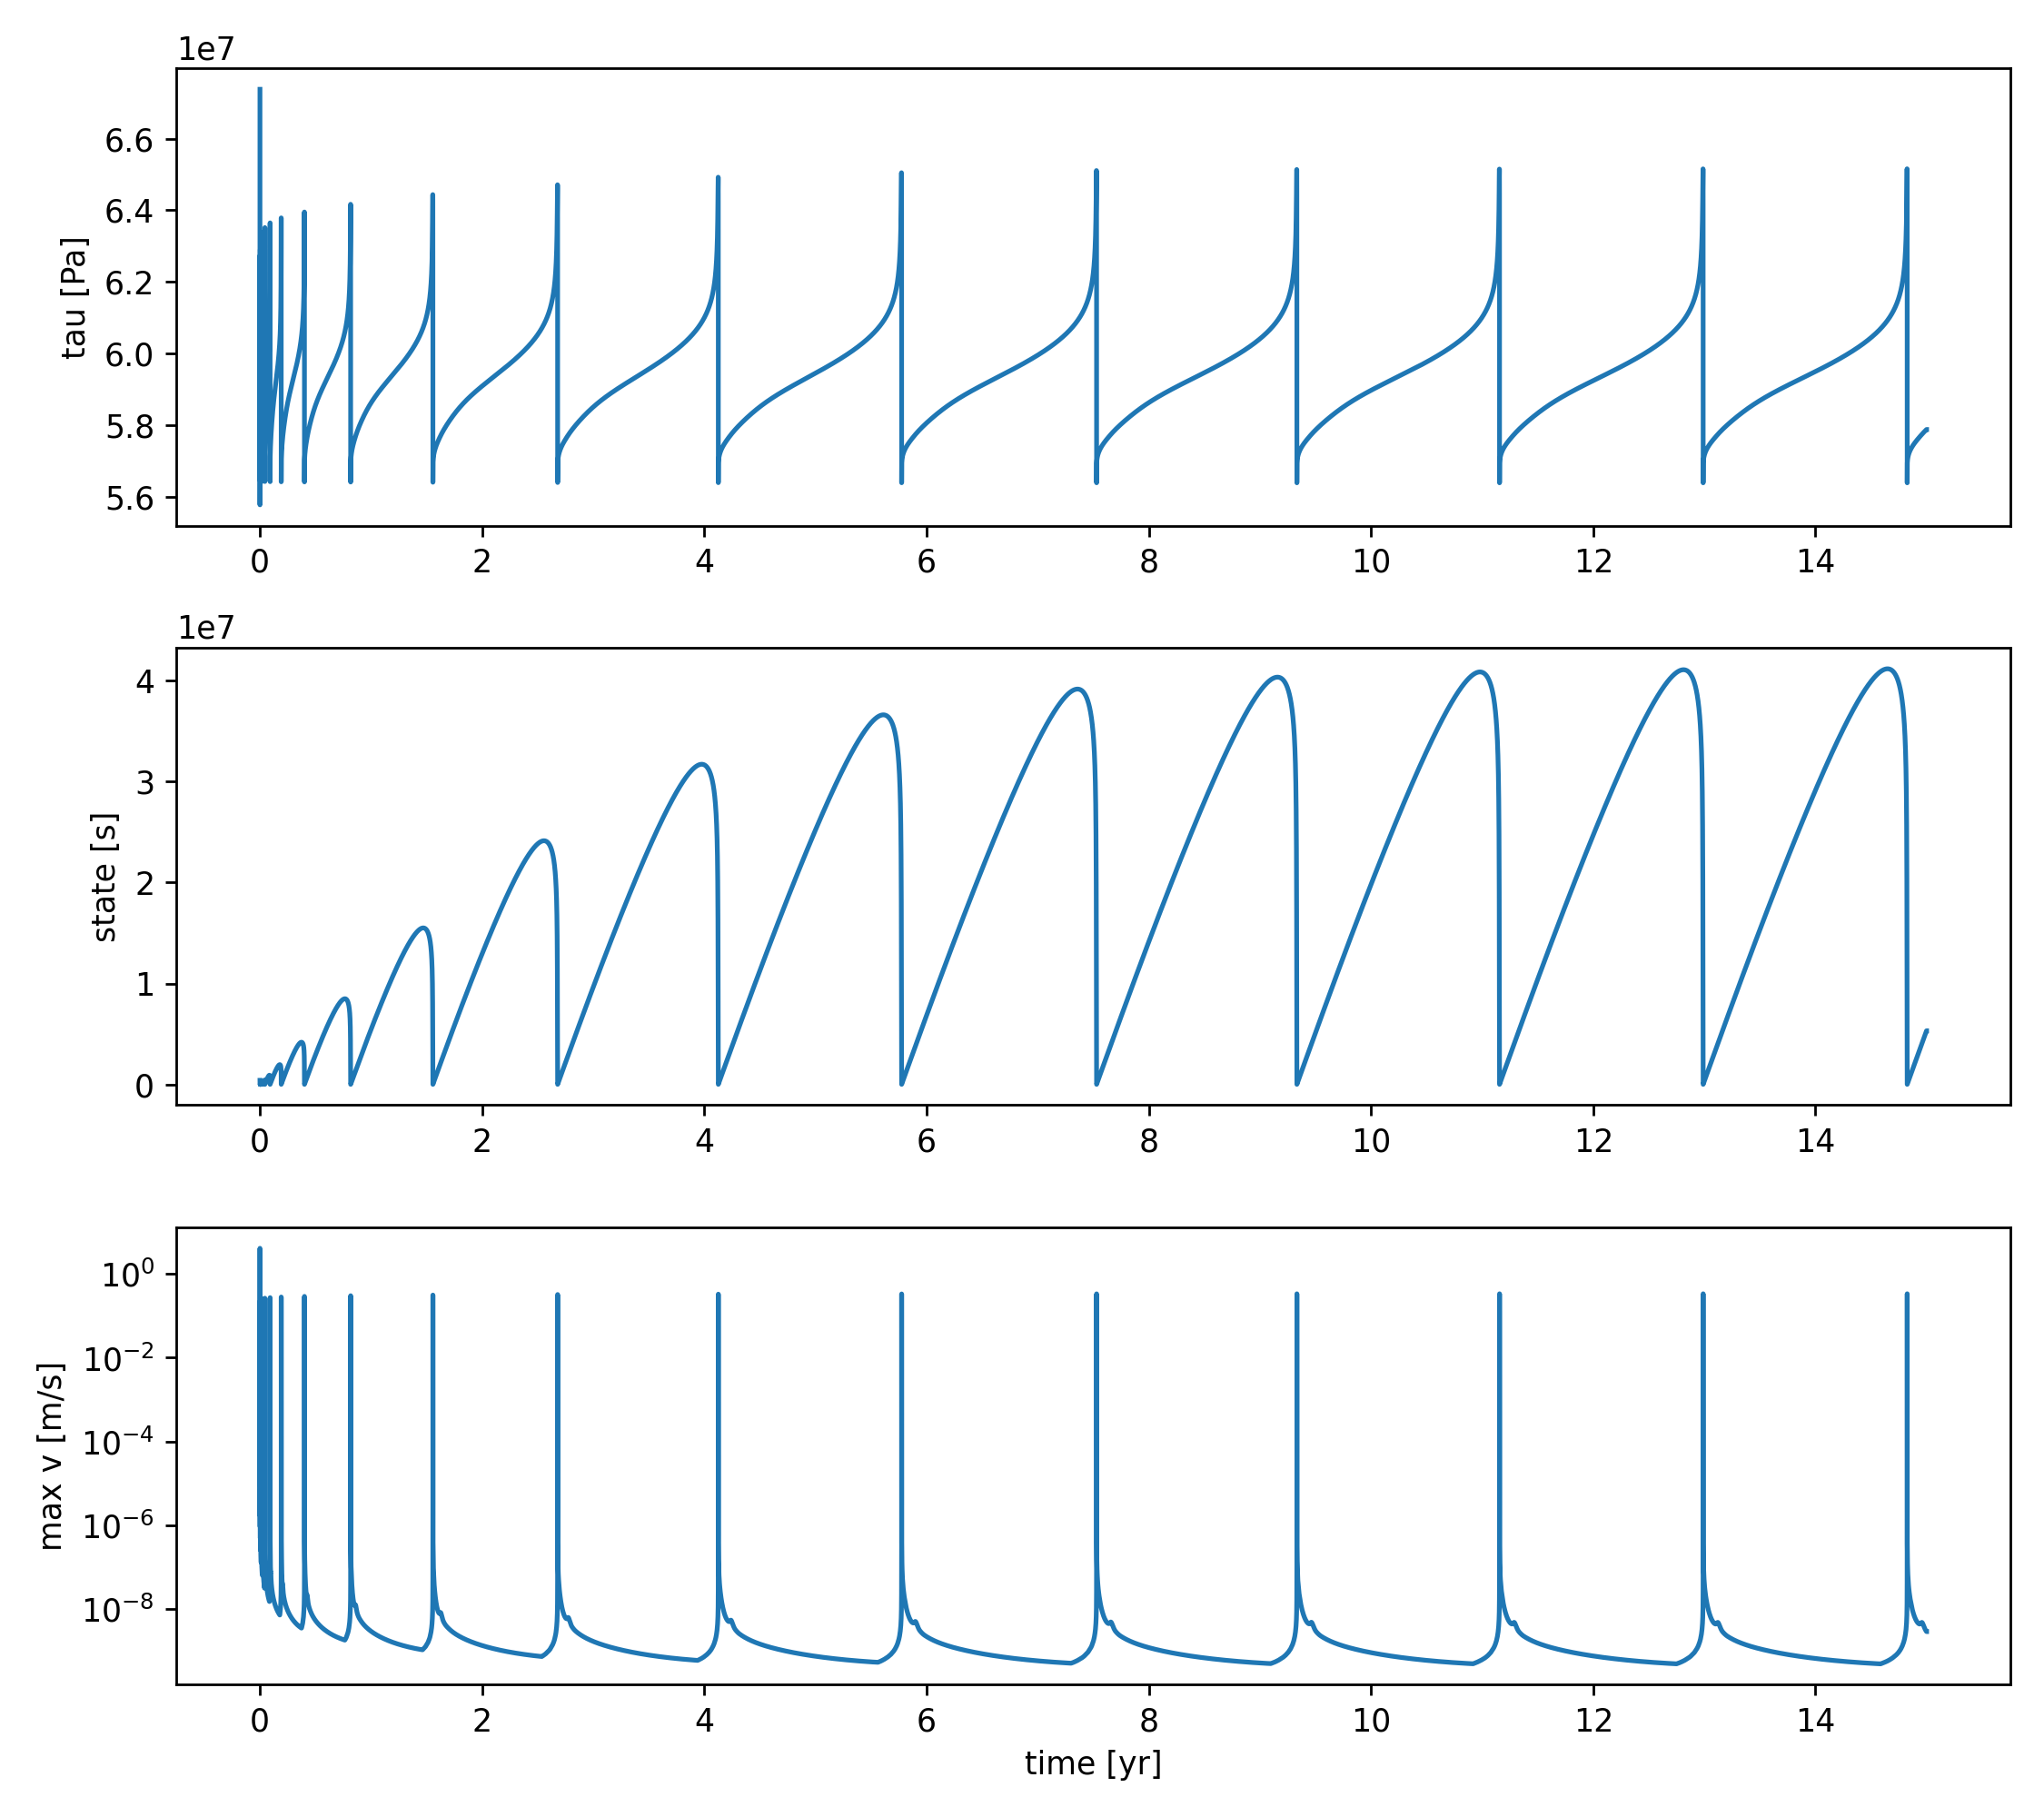

In [6]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

The simulations typically take a few cycles to "warm-up" and to converge to a stable limit cycle. After the warm-up the behaviour of the fault is independent of our choice for initial values. In cases where the fault slip behaviour is chaotic, no stable limit cycle may ever be attained. In our case, a stable limit cycle is attained after about 4 years. To better see what is going on during each cycle, we plot the evolution of the slip rate on the fault from 4 years onwards:

<IPython.core.display.Javascript object>


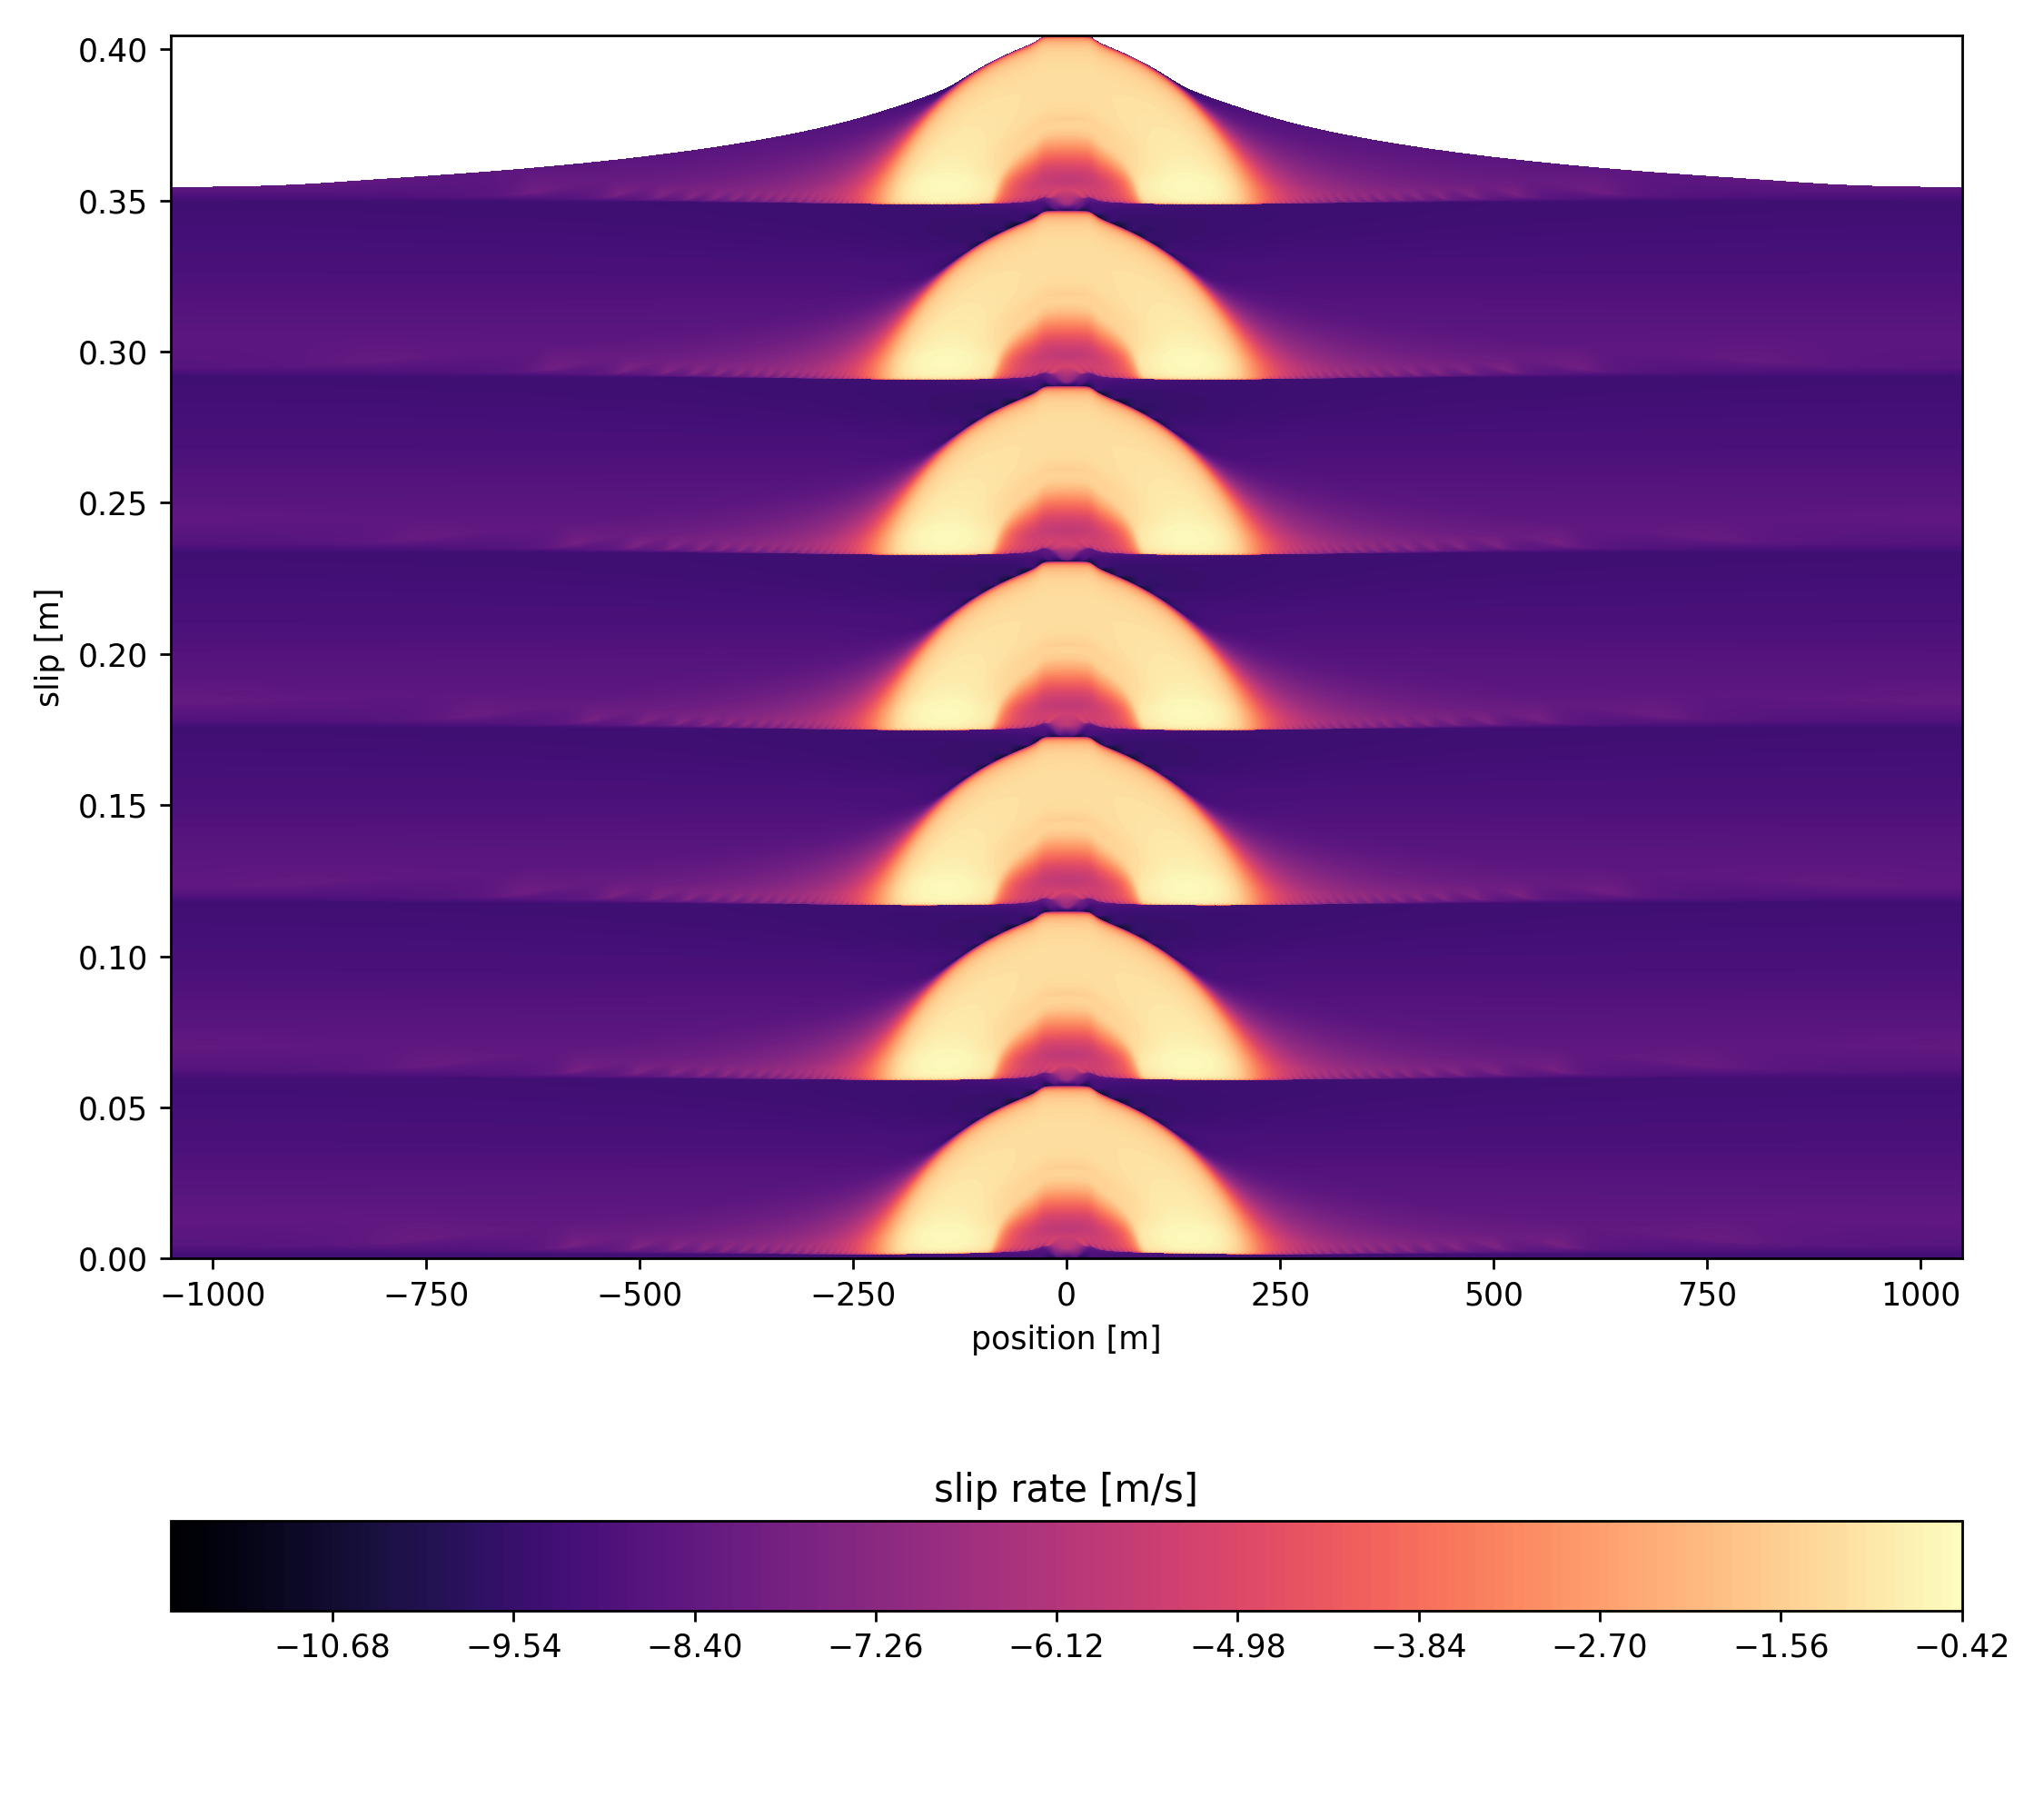

In [7]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=4*t_yr)

In this plot, the warmer colours indicate higher slip rates. The asperity is positioned in the centre of the fault (around $x = 0$). As the fault is progressively loaded, nucleation starts at the centre and the "crack" grows laterally until it enters the matrix, after which it quickly decelerates and the rupture ceases.

This type of plots is perhaps not immediately intuitive, so it helps to look at an animation to get a better sense of the slip evolution on this fault.

In [8]:
# This will take a minute or two...
qdyn_plot.animation_slip(p.ox, warm_up=4*t_yr)